# Plant Disease Detection - YOLOv4 + Ensemble Model
## Kết hợp YOLOv4 và Ensemble Learning cho PlantVillage Dataset

Thực hiện:
1. **YOLOv4** - Object Detection cho phát hiện vùng bệnh
2. **Ensemble Models** - Kết hợp nhiều CNN models (ResNet, EfficientNet, DenseNet) để classification
3. **Training & Testing** - Trên PlantVillage dataset
4. **Evaluation** - So sánh accuracy của các models

## 1. Setup và Import Libraries

In [1]:
# Data processing
import pandas as pd
import numpy as np
import os
from pathlib import Path
import json
import random
from tqdm import tqdm

# Image processing
from PIL import Image
import cv2

# Deep Learning - PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, precision_score, recall_score, f1_score
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
print("Libraries imported successfully!")

PyTorch version: 2.9.0+cu130
Torchvision version: 0.24.0+cu130
Device: cuda
GPU: NVIDIA GeForce RTX 5060 Ti
GPU Memory: 17.10 GB
Libraries imported successfully!


In [2]:
# Check GPU availability
print("=" * 60)
print("GPU CHECK:")
print("=" * 60)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda if torch.cuda.is_available() else 'N/A'}")
print(f"cuDNN version: {torch.backends.cudnn.version() if torch.cuda.is_available() else 'N/A'}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"\nGPU {i}:")
        print(f"  Name: {torch.cuda.get_device_name(i)}")
        print(f"  Compute Capability: {torch.cuda.get_device_capability(i)}")
        print(f"  Memory Total: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB")
        print(f"  Memory Allocated: {torch.cuda.memory_allocated(i) / 1e9:.4f} GB")
        print(f"  Memory Reserved: {torch.cuda.memory_reserved(i) / 1e9:.4f} GB")
    
    # Test GPU computation
    print("\nTesting GPU computation...")
    x = torch.randn(1000, 1000).cuda()
    y = torch.randn(1000, 1000).cuda()
    z = torch.matmul(x, y)
    print("GPU computation test successful!")
else:
    print("\nWARNING: No GPU detected!")
    print("Training will run on CPU (very slow!)")
    print("\nTo fix, install PyTorch with CUDA support:")
    print("  pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu130")

print("=" * 60)

GPU CHECK:
PyTorch version: 2.9.0+cu130
CUDA available: True
CUDA version: 13.0
cuDNN version: 91200
Number of GPUs: 1

GPU 0:
  Name: NVIDIA GeForce RTX 5060 Ti
  Compute Capability: (12, 0)
  Memory Total: 17.10 GB
  Memory Allocated: 0.0000 GB
  Memory Reserved: 0.0000 GB

Testing GPU computation...
GPU computation test successful!


## 2. Configuration và Hyperparameters

In [3]:
# Paths
BASE_PATH = Path(r'g:\Dataset\Data')
PLANT_VILLAGE_PATH = BASE_PATH / 'PlantVIllage' / 'PlantVillage-Dataset-master'
MODEL_SAVE_PATH = Path(r'g:\Dataset\models')
MODEL_SAVE_PATH.mkdir(exist_ok=True)

# Image parameters
IMG_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3

# Training parameters
EPOCHS = 50
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.1

# Early stopping
PATIENCE = 10

# Ensemble configuration
ENSEMBLE_MODELS = [
    'efficientnet_b3',
    'resnet50',
    'densenet121',
    'inception_v3'
]

# Random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
random.seed(SEED)

print("Configuration set!")
print(f"Dataset path: {PLANT_VILLAGE_PATH}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Device: {device}")
print(f"Ensemble models: {ENSEMBLE_MODELS}")

Configuration set!
Dataset path: g:\Dataset\Data\PlantVIllage\PlantVillage-Dataset-master
Image size: 224x224
Batch size: 32
Device: cuda
Ensemble models: ['efficientnet_b3', 'resnet50', 'densenet121', 'inception_v3']


## 3. Load và Prepare PlantVillage Dataset

In [4]:
# Get all class folders
class_folders = [d for d in PLANT_VILLAGE_PATH.iterdir() if d.is_dir()]
class_names = sorted([d.name for d in class_folders])
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"\nClasses:")
for i, cls in enumerate(class_names, 1):
    print(f"{i}. {cls}")

# Create class to index mapping
class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}

Number of classes: 39

Classes:
1. Apple___Apple_scab
2. Apple___Black_rot
3. Apple___Cedar_apple_rust
4. Apple___healthy
5. Blueberry___healthy
6. Cherry_(including_sour)___Powdery_mildew
7. Cherry_(including_sour)___healthy
8. Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
9. Corn_(maize)___Common_rust_
10. Corn_(maize)___Northern_Leaf_Blight
11. Corn_(maize)___healthy
12. Grape___Black_rot
13. Grape___Esca_(Black_Measles)
14. Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
15. Grape___healthy
16. Orange___Haunglongbing_(Citrus_greening)
17. Peach___Bacterial_spot
18. Peach___healthy
19. Pepper,_bell___Bacterial_spot
20. Pepper,_bell___healthy
21. Potato___Early_blight
22. Potato___Late_blight
23. Potato___healthy
24. Raspberry___healthy
25. Soybean___healthy
26. Squash___Powdery_mildew
27. Strawberry___Leaf_scorch
28. Strawberry___healthy
29. Tomato___Bacterial_spot
30. Tomato___Early_blight
31. Tomato___Late_blight
32. Tomato___Leaf_Mold
33. Tomato___Septoria_leaf_spot
34. Tomato___

In [5]:
# Load all image paths and labels
def load_dataset_info(data_path):
    """
    Load all image paths and their corresponding labels
    """
    image_paths = []
    labels = []
    
    for class_name in tqdm(class_names, desc="Loading dataset"):
        class_path = data_path / class_name
        class_idx = class_to_idx[class_name]
        
        # Get all images in this class
        for img_path in class_path.glob('*'):
            if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                image_paths.append(str(img_path))
                labels.append(class_idx)
    
    return np.array(image_paths), np.array(labels)

# Load dataset
X_paths, y = load_dataset_info(PLANT_VILLAGE_PATH)

print(f"\nTotal images: {len(X_paths)}")
print(f"Labels shape: {y.shape}")
print(f"\nLabel distribution:")
unique, counts = np.unique(y, return_counts=True)
for idx, count in zip(unique[:5], counts[:5]):
    print(f"  {idx_to_class[idx]}: {count} images")

Loading dataset: 100%|██████████| 39/39 [00:00<00:00, 349.50it/s]


Total images: 54305
Labels shape: (54305,)

Label distribution:
  Apple___Apple_scab: 630 images
  Apple___Black_rot: 621 images
  Apple___Cedar_apple_rust: 275 images
  Apple___healthy: 1645 images
  Blueberry___healthy: 1502 images


## 4. Split Dataset (Train/Val/Test)

In [6]:
# Split dataset
# First split: Train+Val vs Test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_paths, y, 
    test_size=TEST_SPLIT, 
    random_state=SEED, 
    stratify=y
)

# Second split: Train vs Val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=VALIDATION_SPLIT,
    random_state=SEED,
    stratify=y_train_val
)

print("Dataset split:")
print(f"Train: {len(X_train)} images")
print(f"Validation: {len(X_val)} images")
print(f"Test: {len(X_test)} images")
print(f"\nTrain ratio: {len(X_train)/len(X_paths)*100:.1f}%")
print(f"Val ratio: {len(X_val)/len(X_paths)*100:.1f}%")
print(f"Test ratio: {len(X_test)/len(X_paths)*100:.1f}%")

Dataset split:
Train: 39099 images
Validation: 9775 images
Test: 5431 images

Train ratio: 72.0%
Val ratio: 18.0%
Test ratio: 10.0%


## 5. Custom Dataset Class

In [7]:
class PlantDiseaseDataset(Dataset):
    """
    Custom Dataset for Plant Disease images
    """
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("PlantDiseaseDataset class created!")

PlantDiseaseDataset class created!


In [8]:
# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Data transforms created!")
print("Training: Resize, RandomFlip, Rotation, ColorJitter, Affine, Normalize")
print("Validation/Test: Resize, Normalize")

Data transforms created!
Training: Resize, RandomFlip, Rotation, ColorJitter, Affine, Normalize
Validation/Test: Resize, Normalize


In [9]:
# Create PyTorch datasets
train_dataset = PlantDiseaseDataset(X_train, y_train, transform=train_transform)
val_dataset = PlantDiseaseDataset(X_val, y_val, transform=val_test_transform)
test_dataset = PlantDiseaseDataset(X_test, y_test, transform=val_test_transform)

# Workers: use 0 on Windows to avoid multiprocessing issues in notebooks
import sys
if sys.platform.startswith('win'):
    WORKERS = 0
else:
    WORKERS = 4

# Pin memory only if CUDA is available
PIN_MEMORY = True if torch.cuda.is_available() else False

# Create DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=WORKERS, 
    pin_memory=PIN_MEMORY
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=WORKERS, 
    pin_memory=PIN_MEMORY
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=WORKERS, 
    pin_memory=PIN_MEMORY
)

print(f"\nDataLoaders created! (workers={WORKERS}, pin_memory={PIN_MEMORY})")
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


DataLoaders created! (workers=0, pin_memory=True)
Train batches: 1222
Validation batches: 306
Test batches: 170


## 6. Build Individual Models

In [10]:
def build_model(model_name, num_classes, pretrained=True):
    """
    Build a transfer learning model with specified architecture
    """
    if model_name == 'efficientnet_b3':
        model = models.efficientnet_b3(pretrained=pretrained)
        num_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.3, inplace=True),
            nn.Linear(num_features, num_classes)
        )
    
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=pretrained)
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    elif model_name == 'densenet121':
        model = models.densenet121(pretrained=pretrained)
        num_features = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    elif model_name == 'inception_v3':
        if pretrained:
            # Load pretrained model with aux_logits=True (required for pretrained weights)
            model = models.inception_v3(pretrained=True, aux_logits=True)
            # Disable aux_logits after loading weights
            model.aux_logits = False
            model.AuxLogits = None
        else:
            model = models.inception_v3(pretrained=False, aux_logits=False)
        
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    else:
        raise ValueError(f"Unknown model: {model_name}")
    
    return model

# Test model creation
for model_name in ENSEMBLE_MODELS:
    model = build_model(model_name, num_classes)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{model_name}:")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    print()

print("Model builder function created!")

efficientnet_b3:
  Total parameters: 10,756,175
  Trainable parameters: 10,756,175

resnet50:
  Total parameters: 24,577,127
  Trainable parameters: 24,577,127

densenet121:
  Total parameters: 7,498,663
  Trainable parameters: 7,498,663

inception_v3:
  Total parameters: 22,854,663
  Trainable parameters: 22,854,663

Model builder function created!
densenet121:
  Total parameters: 7,498,663
  Trainable parameters: 7,498,663

inception_v3:
  Total parameters: 22,854,663
  Trainable parameters: 22,854,663

Model builder function created!


## 7. Training and Evaluation Functions

In [11]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train for one epoch
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({
            'loss': f'{running_loss/total:.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion, device):
    """
    Validate the model
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels


def train_model(model, train_loader, val_loader, criterion, optimizer, 
                scheduler, num_epochs, device, model_name, patience=10):
    """
    Complete training loop with early stopping
    """
    best_val_acc = 0.0
    best_model_wts = None
    epochs_no_improve = 0
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 60)
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
        
        # Update scheduler
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Early stopping and save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict().copy()
            epochs_no_improve = 0
            
            # Save checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss,
            }, MODEL_SAVE_PATH / f'{model_name}_best.pth')
            print(f'Saved best model with val_acc: {val_acc:.4f}')
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f'\nEarly stopping triggered after {epoch+1} epochs')
            break
    
    # Load best model weights
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
    
    return model, history

print("Training functions created!")

Training functions created!


## 8. Train Individual Models

In [12]:
# Quick DataLoader smoke test: fetch one batch and show shapes
print('Running quick DataLoader test...')
try:
    batch = next(iter(train_loader))
    images, labels = batch
    print('Train batch - images shape:', images.shape)
    print('Train batch - labels shape:', labels.shape)
    # Move a small batch to device to ensure GPU path works
    images = images[:2].to(device)
    labels = labels[:2].to(device)
    with torch.no_grad():
        out = torch.zeros(1)  # dummy placeholder
        if torch.cuda.is_available():
            _ = images * 1  # quick op to ensure CUDA tensor ops succeed
            print('CUDA operations OK')
    print('DataLoader smoke test passed')
except Exception as e:
    print('DataLoader smoke test failed:', repr(e))
    import traceback
    traceback.print_exc()

Running quick DataLoader test...
Train batch - images shape: torch.Size([32, 3, 224, 224])
Train batch - labels shape: torch.Size([32])
CUDA operations OK
DataLoader smoke test passed


In [13]:
# Dictionary to store trained models and histories
trained_models = {}
training_histories = {}

# Train each model
for model_name in ENSEMBLE_MODELS:
    print(f"\n{'='*70}")
    print(f"Training {model_name}")
    print(f"{'='*70}")
    
    # Build model
    model = build_model(model_name, num_classes, pretrained=True)
    model = model.to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nModel: {model_name}")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Train model
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=EPOCHS,
        device=device,
        model_name=model_name,
        patience=PATIENCE
    )
    
    # Store model and history
    trained_models[model_name] = model
    training_histories[model_name] = history
    
    print(f"\n{model_name} training completed!")
    print(f"Best val_accuracy: {max(history['val_acc']):.4f}")

print("\n" + "="*70)
print("All models trained!")
print("="*70)


Training efficientnet_b3

Model: efficientnet_b3
Total parameters: 10,756,175
Trainable parameters: 10,756,175

Epoch 1/50
------------------------------------------------------------

Model: efficientnet_b3
Total parameters: 10,756,175
Trainable parameters: 10,756,175

Epoch 1/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:23<00:00, 13.03it/s]



Train Loss: 0.3529 | Train Acc: 0.8949
Val Loss: 0.0732 | Val Acc: 0.9775
Learning Rate: 0.001000
Saved best model with val_acc: 0.9775

Epoch 2/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:22<00:00, 13.42it/s]


Train Loss: 0.1547 | Train Acc: 0.9503
Val Loss: 0.1884 | Val Acc: 0.9451
Learning Rate: 0.001000

Epoch 3/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:23<00:00, 13.17it/s]



Train Loss: 0.1379 | Train Acc: 0.9549
Val Loss: 0.0457 | Val Acc: 0.9852
Learning Rate: 0.001000
Saved best model with val_acc: 0.9852

Epoch 4/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:23<00:00, 13.21it/s]


Train Loss: 0.1230 | Train Acc: 0.9596
Val Loss: 0.0761 | Val Acc: 0.9753
Learning Rate: 0.001000

Epoch 5/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:22<00:00, 13.31it/s]


Train Loss: 0.1168 | Train Acc: 0.9628
Val Loss: 0.1097 | Val Acc: 0.9652
Learning Rate: 0.001000

Epoch 6/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:23<00:00, 13.29it/s]


Train Loss: 0.1052 | Train Acc: 0.9660
Val Loss: 0.0546 | Val Acc: 0.9829
Learning Rate: 0.001000

Epoch 7/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:23<00:00, 13.19it/s]


Train Loss: 0.1042 | Train Acc: 0.9669
Val Loss: 0.0523 | Val Acc: 0.9845
Learning Rate: 0.001000

Epoch 8/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:23<00:00, 13.16it/s]


Train Loss: 0.0965 | Train Acc: 0.9695
Val Loss: 0.0663 | Val Acc: 0.9820
Learning Rate: 0.001000

Epoch 9/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:23<00:00, 13.03it/s]


Train Loss: 0.0935 | Train Acc: 0.9701
Val Loss: 0.0524 | Val Acc: 0.9825
Learning Rate: 0.000500

Epoch 10/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:23<00:00, 13.15it/s]



Train Loss: 0.0472 | Train Acc: 0.9843
Val Loss: 0.0259 | Val Acc: 0.9916
Learning Rate: 0.000500
Saved best model with val_acc: 0.9916

Epoch 11/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:23<00:00, 13.13it/s]


Train Loss: 0.0503 | Train Acc: 0.9844
Val Loss: 0.0287 | Val Acc: 0.9910
Learning Rate: 0.000500

Epoch 12/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:23<00:00, 13.11it/s]



Train Loss: 0.0497 | Train Acc: 0.9841
Val Loss: 0.0185 | Val Acc: 0.9938
Learning Rate: 0.000500
Saved best model with val_acc: 0.9938

Epoch 13/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:23<00:00, 13.09it/s]


Train Loss: 0.0447 | Train Acc: 0.9858
Val Loss: 0.0193 | Val Acc: 0.9938
Learning Rate: 0.000500

Epoch 14/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:23<00:00, 13.17it/s]



Train Loss: 0.0494 | Train Acc: 0.9851
Val Loss: 0.0191 | Val Acc: 0.9941
Learning Rate: 0.000500
Saved best model with val_acc: 0.9941

Epoch 15/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:23<00:00, 13.15it/s]


Train Loss: 0.0458 | Train Acc: 0.9854
Val Loss: 0.0311 | Val Acc: 0.9895
Learning Rate: 0.000500

Epoch 16/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:23<00:00, 13.02it/s]


Train Loss: 0.0449 | Train Acc: 0.9854
Val Loss: 0.0281 | Val Acc: 0.9913
Learning Rate: 0.000500

Epoch 17/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:23<00:00, 12.97it/s]



Train Loss: 0.0458 | Train Acc: 0.9860
Val Loss: 0.0187 | Val Acc: 0.9943
Learning Rate: 0.000500
Saved best model with val_acc: 0.9943

Epoch 18/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:23<00:00, 13.09it/s]


Train Loss: 0.0452 | Train Acc: 0.9866
Val Loss: 0.0273 | Val Acc: 0.9915
Learning Rate: 0.000250

Epoch 19/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.68it/s]



Train Loss: 0.0263 | Train Acc: 0.9919
Val Loss: 0.0149 | Val Acc: 0.9951
Learning Rate: 0.000250
Saved best model with val_acc: 0.9951

Epoch 20/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:23<00:00, 12.96it/s]



Train Loss: 0.0263 | Train Acc: 0.9922
Val Loss: 0.0146 | Val Acc: 0.9964
Learning Rate: 0.000250
Saved best model with val_acc: 0.9964

Epoch 21/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:23<00:00, 13.04it/s]


Train Loss: 0.0250 | Train Acc: 0.9929
Val Loss: 0.0142 | Val Acc: 0.9947
Learning Rate: 0.000250

Epoch 22/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:23<00:00, 13.12it/s]


Train Loss: 0.0254 | Train Acc: 0.9923
Val Loss: 0.0214 | Val Acc: 0.9930
Learning Rate: 0.000250

Epoch 23/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:23<00:00, 13.00it/s]


Train Loss: 0.0258 | Train Acc: 0.9923
Val Loss: 0.0153 | Val Acc: 0.9949
Learning Rate: 0.000250

Epoch 24/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:23<00:00, 13.12it/s]


Train Loss: 0.0275 | Train Acc: 0.9918
Val Loss: 0.0132 | Val Acc: 0.9958
Learning Rate: 0.000250

Epoch 25/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:23<00:00, 13.05it/s]


Train Loss: 0.0269 | Train Acc: 0.9925
Val Loss: 0.0133 | Val Acc: 0.9958
Learning Rate: 0.000250

Epoch 26/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:23<00:00, 12.98it/s]


Train Loss: 0.0255 | Train Acc: 0.9928
Val Loss: 0.0133 | Val Acc: 0.9962
Learning Rate: 0.000250

Epoch 27/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:23<00:00, 13.07it/s]


Train Loss: 0.0260 | Train Acc: 0.9924
Val Loss: 0.0141 | Val Acc: 0.9954
Learning Rate: 0.000250

Epoch 28/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:23<00:00, 13.09it/s]


Train Loss: 0.0266 | Train Acc: 0.9919
Val Loss: 0.0161 | Val Acc: 0.9952
Learning Rate: 0.000250

Epoch 29/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:23<00:00, 12.96it/s]


Train Loss: 0.0273 | Train Acc: 0.9918
Val Loss: 0.0166 | Val Acc: 0.9940
Learning Rate: 0.000250

Epoch 30/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:23<00:00, 13.07it/s]



Train Loss: 0.0255 | Train Acc: 0.9928
Val Loss: 0.0147 | Val Acc: 0.9953
Learning Rate: 0.000125

Early stopping triggered after 30 epochs

efficientnet_b3 training completed!
Best val_accuracy: 0.9964

Training resnet50

Model: resnet50
Total parameters: 24,577,127
Trainable parameters: 24,577,127

Epoch 1/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.63it/s]



Train Loss: 1.4447 | Train Acc: 0.5757
Val Loss: 0.7946 | Val Acc: 0.7395
Learning Rate: 0.001000
Saved best model with val_acc: 0.7395

Epoch 2/50
------------------------------------------------------------
Saved best model with val_acc: 0.7395

Epoch 2/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.68it/s]



Train Loss: 0.6826 | Train Acc: 0.7816
Val Loss: 0.4479 | Val Acc: 0.8571
Learning Rate: 0.001000
Saved best model with val_acc: 0.8571

Epoch 3/50
------------------------------------------------------------
Saved best model with val_acc: 0.8571

Epoch 3/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.46it/s]



Train Loss: 0.4760 | Train Acc: 0.8471
Val Loss: 0.2889 | Val Acc: 0.9072
Learning Rate: 0.001000
Saved best model with val_acc: 0.9072

Epoch 4/50
------------------------------------------------------------
Saved best model with val_acc: 0.9072

Epoch 4/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.49it/s]



Train Loss: 0.3810 | Train Acc: 0.8809
Val Loss: 0.2086 | Val Acc: 0.9273
Learning Rate: 0.001000
Saved best model with val_acc: 0.9273

Epoch 5/50
------------------------------------------------------------
Saved best model with val_acc: 0.9273

Epoch 5/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.56it/s]



Train Loss: 0.3312 | Train Acc: 0.8917
Val Loss: 0.2237 | Val Acc: 0.9301
Learning Rate: 0.001000
Saved best model with val_acc: 0.9301

Epoch 6/50
------------------------------------------------------------
Saved best model with val_acc: 0.9301

Epoch 6/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.55it/s]



Train Loss: 0.2988 | Train Acc: 0.9028
Val Loss: 0.1764 | Val Acc: 0.9418
Learning Rate: 0.001000
Saved best model with val_acc: 0.9418

Epoch 7/50
------------------------------------------------------------
Saved best model with val_acc: 0.9418

Epoch 7/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.45it/s]



Train Loss: 0.2753 | Train Acc: 0.9116
Val Loss: 0.1624 | Val Acc: 0.9473
Learning Rate: 0.001000
Saved best model with val_acc: 0.9473

Epoch 8/50
------------------------------------------------------------
Saved best model with val_acc: 0.9473

Epoch 8/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.62it/s]


Train Loss: 0.2583 | Train Acc: 0.9170
Val Loss: 0.2016 | Val Acc: 0.9332
Learning Rate: 0.001000

Epoch 9/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.62it/s]



Train Loss: 0.2444 | Train Acc: 0.9205
Val Loss: 0.1294 | Val Acc: 0.9582
Learning Rate: 0.001000
Saved best model with val_acc: 0.9582

Epoch 10/50
------------------------------------------------------------
Saved best model with val_acc: 0.9582

Epoch 10/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.54it/s]


Train Loss: 0.2260 | Train Acc: 0.9272
Val Loss: 0.1751 | Val Acc: 0.9422
Learning Rate: 0.001000

Epoch 11/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.65it/s]



Train Loss: 0.2207 | Train Acc: 0.9295
Val Loss: 0.0934 | Val Acc: 0.9666
Learning Rate: 0.001000
Saved best model with val_acc: 0.9666

Epoch 12/50
------------------------------------------------------------
Saved best model with val_acc: 0.9666

Epoch 12/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.65it/s]


Train Loss: 0.2108 | Train Acc: 0.9309
Val Loss: 0.1458 | Val Acc: 0.9511
Learning Rate: 0.001000

Epoch 13/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.65it/s]


Train Loss: 0.2014 | Train Acc: 0.9369
Val Loss: 0.1700 | Val Acc: 0.9462
Learning Rate: 0.001000

Epoch 14/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.68it/s]



Train Loss: 0.1916 | Train Acc: 0.9383
Val Loss: 0.0942 | Val Acc: 0.9690
Learning Rate: 0.001000
Saved best model with val_acc: 0.9690

Epoch 15/50
------------------------------------------------------------
Saved best model with val_acc: 0.9690

Epoch 15/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.62it/s]



Train Loss: 0.1943 | Train Acc: 0.9383
Val Loss: 0.0847 | Val Acc: 0.9735
Learning Rate: 0.001000
Saved best model with val_acc: 0.9735

Epoch 16/50
------------------------------------------------------------
Saved best model with val_acc: 0.9735

Epoch 16/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.50it/s]


Train Loss: 0.1817 | Train Acc: 0.9415
Val Loss: 0.1134 | Val Acc: 0.9634
Learning Rate: 0.001000

Epoch 17/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.65it/s]


Train Loss: 0.1821 | Train Acc: 0.9406
Val Loss: 0.1097 | Val Acc: 0.9629
Learning Rate: 0.001000

Epoch 18/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.66it/s]


Train Loss: 0.1847 | Train Acc: 0.9408
Val Loss: 0.1004 | Val Acc: 0.9663
Learning Rate: 0.001000

Epoch 19/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.72it/s]


Train Loss: 0.1747 | Train Acc: 0.9432
Val Loss: 0.1098 | Val Acc: 0.9636
Learning Rate: 0.001000

Epoch 20/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.61it/s]


Train Loss: 0.1701 | Train Acc: 0.9448
Val Loss: 0.0836 | Val Acc: 0.9715
Learning Rate: 0.001000

Epoch 21/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.56it/s]


Train Loss: 0.1700 | Train Acc: 0.9448
Val Loss: 0.1333 | Val Acc: 0.9554
Learning Rate: 0.001000

Epoch 22/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.59it/s]



Train Loss: 0.1693 | Train Acc: 0.9456
Val Loss: 0.0591 | Val Acc: 0.9796
Learning Rate: 0.001000
Saved best model with val_acc: 0.9796

Epoch 23/50
------------------------------------------------------------
Saved best model with val_acc: 0.9796

Epoch 23/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.56it/s]


Train Loss: 0.1611 | Train Acc: 0.9495
Val Loss: 0.0913 | Val Acc: 0.9704
Learning Rate: 0.001000

Epoch 24/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.64it/s]


Train Loss: 0.1619 | Train Acc: 0.9474
Val Loss: 0.0841 | Val Acc: 0.9709
Learning Rate: 0.001000

Epoch 25/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.64it/s]


Train Loss: 0.1663 | Train Acc: 0.9462
Val Loss: 0.0935 | Val Acc: 0.9705
Learning Rate: 0.001000

Epoch 26/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.58it/s]


Train Loss: 0.1547 | Train Acc: 0.9504
Val Loss: 0.0625 | Val Acc: 0.9789
Learning Rate: 0.001000

Epoch 27/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.64it/s]



Train Loss: 0.1542 | Train Acc: 0.9509
Val Loss: 0.0501 | Val Acc: 0.9826
Learning Rate: 0.001000
Saved best model with val_acc: 0.9826

Epoch 28/50
------------------------------------------------------------
Saved best model with val_acc: 0.9826

Epoch 28/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.66it/s]


Train Loss: 0.1529 | Train Acc: 0.9504
Val Loss: 0.0827 | Val Acc: 0.9708
Learning Rate: 0.001000

Epoch 29/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.56it/s]


Train Loss: 0.1480 | Train Acc: 0.9528
Val Loss: 0.0977 | Val Acc: 0.9673
Learning Rate: 0.001000

Epoch 30/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.68it/s]


Train Loss: 0.1463 | Train Acc: 0.9528
Val Loss: 0.1205 | Val Acc: 0.9602
Learning Rate: 0.001000

Epoch 31/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.73it/s]


Train Loss: 0.1498 | Train Acc: 0.9517
Val Loss: 0.1029 | Val Acc: 0.9654
Learning Rate: 0.001000

Epoch 32/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.70it/s]



Train Loss: 0.1495 | Train Acc: 0.9515
Val Loss: 0.0532 | Val Acc: 0.9830
Learning Rate: 0.001000
Saved best model with val_acc: 0.9830

Epoch 33/50
------------------------------------------------------------
Saved best model with val_acc: 0.9830

Epoch 33/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.62it/s]


Train Loss: 0.1480 | Train Acc: 0.9520
Val Loss: 0.1162 | Val Acc: 0.9636
Learning Rate: 0.000500

Epoch 34/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.69it/s]



Train Loss: 0.0926 | Train Acc: 0.9697
Val Loss: 0.0407 | Val Acc: 0.9868
Learning Rate: 0.000500
Saved best model with val_acc: 0.9868

Epoch 35/50
------------------------------------------------------------
Saved best model with val_acc: 0.9868

Epoch 35/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.60it/s]



Train Loss: 0.0853 | Train Acc: 0.9718
Val Loss: 0.0334 | Val Acc: 0.9884
Learning Rate: 0.000500
Saved best model with val_acc: 0.9884

Epoch 36/50
------------------------------------------------------------
Saved best model with val_acc: 0.9884

Epoch 36/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.68it/s]



Train Loss: 0.0892 | Train Acc: 0.9712
Val Loss: 0.0343 | Val Acc: 0.9886
Learning Rate: 0.000500
Saved best model with val_acc: 0.9886

Epoch 37/50
------------------------------------------------------------
Saved best model with val_acc: 0.9886

Epoch 37/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.64it/s]



Train Loss: 0.0844 | Train Acc: 0.9731
Val Loss: 0.0298 | Val Acc: 0.9901
Learning Rate: 0.000500
Saved best model with val_acc: 0.9901

Epoch 38/50
------------------------------------------------------------
Saved best model with val_acc: 0.9901

Epoch 38/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.54it/s]


Train Loss: 0.0837 | Train Acc: 0.9729
Val Loss: 0.0379 | Val Acc: 0.9879
Learning Rate: 0.000500

Epoch 39/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.58it/s]



Train Loss: 0.0830 | Train Acc: 0.9736
Val Loss: 0.0268 | Val Acc: 0.9913
Learning Rate: 0.000500
Saved best model with val_acc: 0.9913

Epoch 40/50
------------------------------------------------------------
Saved best model with val_acc: 0.9913

Epoch 40/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.56it/s]


Train Loss: 0.0812 | Train Acc: 0.9742
Val Loss: 0.0510 | Val Acc: 0.9843
Learning Rate: 0.000500

Epoch 41/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.52it/s]


Train Loss: 0.0834 | Train Acc: 0.9734
Val Loss: 0.0345 | Val Acc: 0.9892
Learning Rate: 0.000500

Epoch 42/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.47it/s]


Train Loss: 0.0827 | Train Acc: 0.9729
Val Loss: 0.0316 | Val Acc: 0.9886
Learning Rate: 0.000500

Epoch 43/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.58it/s]


Train Loss: 0.0797 | Train Acc: 0.9742
Val Loss: 0.0405 | Val Acc: 0.9856
Learning Rate: 0.000500

Epoch 44/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.50it/s]


Train Loss: 0.0812 | Train Acc: 0.9737
Val Loss: 0.0304 | Val Acc: 0.9895
Learning Rate: 0.000500

Epoch 45/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.65it/s]


Train Loss: 0.0783 | Train Acc: 0.9746
Val Loss: 0.0380 | Val Acc: 0.9879
Learning Rate: 0.000250

Epoch 46/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.67it/s]



Train Loss: 0.0549 | Train Acc: 0.9827
Val Loss: 0.0198 | Val Acc: 0.9937
Learning Rate: 0.000250
Saved best model with val_acc: 0.9937

Epoch 47/50
------------------------------------------------------------
Saved best model with val_acc: 0.9937

Epoch 47/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.63it/s]


Train Loss: 0.0507 | Train Acc: 0.9835
Val Loss: 0.0202 | Val Acc: 0.9919
Learning Rate: 0.000250

Epoch 48/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.61it/s]


Train Loss: 0.0553 | Train Acc: 0.9821
Val Loss: 0.0269 | Val Acc: 0.9904
Learning Rate: 0.000250

Epoch 49/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.69it/s]


Train Loss: 0.0525 | Train Acc: 0.9832
Val Loss: 0.0225 | Val Acc: 0.9926
Learning Rate: 0.000250

Epoch 50/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.66it/s]



Train Loss: 0.0473 | Train Acc: 0.9847
Val Loss: 0.0190 | Val Acc: 0.9929
Learning Rate: 0.000250

resnet50 training completed!
Best val_accuracy: 0.9937

Training densenet121

Model: densenet121
Total parameters: 7,498,663
Trainable parameters: 7,498,663

Epoch 1/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 12.00it/s]



Train Loss: 0.8128 | Train Acc: 0.7562
Val Loss: 0.2783 | Val Acc: 0.9037
Learning Rate: 0.001000
Saved best model with val_acc: 0.9037

Epoch 2/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 11.99it/s]



Train Loss: 0.3763 | Train Acc: 0.8819
Val Loss: 0.1763 | Val Acc: 0.9432
Learning Rate: 0.001000
Saved best model with val_acc: 0.9432

Epoch 3/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 11.91it/s]



Train Loss: 0.3078 | Train Acc: 0.9040
Val Loss: 0.1384 | Val Acc: 0.9557
Learning Rate: 0.001000
Saved best model with val_acc: 0.9557

Epoch 4/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 12.10it/s]



Train Loss: 0.2708 | Train Acc: 0.9161
Val Loss: 0.0950 | Val Acc: 0.9666
Learning Rate: 0.001000
Saved best model with val_acc: 0.9666

Epoch 5/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 12.03it/s]


Train Loss: 0.2559 | Train Acc: 0.9216
Val Loss: 0.1694 | Val Acc: 0.9442
Learning Rate: 0.001000

Epoch 6/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 12.12it/s]



Train Loss: 0.2283 | Train Acc: 0.9287
Val Loss: 0.0859 | Val Acc: 0.9692
Learning Rate: 0.001000
Saved best model with val_acc: 0.9692

Epoch 7/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 12.07it/s]



Train Loss: 0.2144 | Train Acc: 0.9336
Val Loss: 0.1198 | Val Acc: 0.9693
Learning Rate: 0.001000
Saved best model with val_acc: 0.9693

Epoch 8/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 11.91it/s]



Train Loss: 0.2020 | Train Acc: 0.9370
Val Loss: 0.0896 | Val Acc: 0.9733
Learning Rate: 0.001000
Saved best model with val_acc: 0.9733

Epoch 9/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 11.91it/s]



Train Loss: 0.1882 | Train Acc: 0.9421
Val Loss: 0.0677 | Val Acc: 0.9787
Learning Rate: 0.001000
Saved best model with val_acc: 0.9787

Epoch 10/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 12.03it/s]


Train Loss: 0.1866 | Train Acc: 0.9415
Val Loss: 0.0976 | Val Acc: 0.9698
Learning Rate: 0.001000

Epoch 11/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 11.97it/s]


Train Loss: 0.1719 | Train Acc: 0.9465
Val Loss: 0.0643 | Val Acc: 0.9787
Learning Rate: 0.001000

Epoch 12/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 12.04it/s]


Train Loss: 0.1715 | Train Acc: 0.9470
Val Loss: 0.0854 | Val Acc: 0.9730
Learning Rate: 0.001000

Epoch 13/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 12.04it/s]



Train Loss: 0.1619 | Train Acc: 0.9505
Val Loss: 0.0538 | Val Acc: 0.9825
Learning Rate: 0.001000
Saved best model with val_acc: 0.9825

Epoch 14/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 11.96it/s]


Train Loss: 0.1626 | Train Acc: 0.9489
Val Loss: 0.0520 | Val Acc: 0.9820
Learning Rate: 0.001000

Epoch 15/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 11.99it/s]



Train Loss: 0.1526 | Train Acc: 0.9516
Val Loss: 0.0465 | Val Acc: 0.9838
Learning Rate: 0.001000
Saved best model with val_acc: 0.9838

Epoch 16/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 11.94it/s]


Train Loss: 0.1522 | Train Acc: 0.9514
Val Loss: 0.0475 | Val Acc: 0.9835
Learning Rate: 0.001000

Epoch 17/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 12.07it/s]


Train Loss: 0.1416 | Train Acc: 0.9549
Val Loss: 0.0710 | Val Acc: 0.9794
Learning Rate: 0.001000

Epoch 18/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 12.00it/s]



Train Loss: 0.1468 | Train Acc: 0.9536
Val Loss: 0.0485 | Val Acc: 0.9839
Learning Rate: 0.001000
Saved best model with val_acc: 0.9839

Epoch 19/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 11.99it/s]


Train Loss: 0.1332 | Train Acc: 0.9580
Val Loss: 0.0499 | Val Acc: 0.9831
Learning Rate: 0.001000

Epoch 20/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 12.01it/s]


Train Loss: 0.1380 | Train Acc: 0.9562
Val Loss: 0.0565 | Val Acc: 0.9818
Learning Rate: 0.001000

Epoch 21/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 12.08it/s]


Train Loss: 0.1343 | Train Acc: 0.9567
Val Loss: 0.0574 | Val Acc: 0.9826
Learning Rate: 0.000500

Epoch 22/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.25it/s]



Train Loss: 0.0756 | Train Acc: 0.9755
Val Loss: 0.0293 | Val Acc: 0.9896
Learning Rate: 0.000500
Saved best model with val_acc: 0.9896

Epoch 23/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 12.24it/s]



Train Loss: 0.0765 | Train Acc: 0.9762
Val Loss: 0.0263 | Val Acc: 0.9908
Learning Rate: 0.000500
Saved best model with val_acc: 0.9908

Epoch 24/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 12.20it/s]



Train Loss: 0.0715 | Train Acc: 0.9770
Val Loss: 0.0234 | Val Acc: 0.9921
Learning Rate: 0.000500
Saved best model with val_acc: 0.9921

Epoch 25/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 11.97it/s]



Train Loss: 0.0721 | Train Acc: 0.9765
Val Loss: 0.0215 | Val Acc: 0.9925
Learning Rate: 0.000500
Saved best model with val_acc: 0.9925

Epoch 26/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.30it/s]


Train Loss: 0.0693 | Train Acc: 0.9778
Val Loss: 0.0239 | Val Acc: 0.9917
Learning Rate: 0.000500

Epoch 27/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 12.13it/s]


Train Loss: 0.0707 | Train Acc: 0.9765
Val Loss: 0.0284 | Val Acc: 0.9911
Learning Rate: 0.000500

Epoch 28/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 11.84it/s]


Train Loss: 0.0683 | Train Acc: 0.9781
Val Loss: 0.0321 | Val Acc: 0.9892
Learning Rate: 0.000500

Epoch 29/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 11.80it/s]


Train Loss: 0.0675 | Train Acc: 0.9785
Val Loss: 0.0274 | Val Acc: 0.9905
Learning Rate: 0.000500

Epoch 30/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.31it/s]


Train Loss: 0.0702 | Train Acc: 0.9777
Val Loss: 0.0299 | Val Acc: 0.9903
Learning Rate: 0.000500

Epoch 31/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 12.00it/s]


Train Loss: 0.0684 | Train Acc: 0.9785
Val Loss: 0.0249 | Val Acc: 0.9912
Learning Rate: 0.000250

Epoch 32/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 12.18it/s]



Train Loss: 0.0436 | Train Acc: 0.9868
Val Loss: 0.0149 | Val Acc: 0.9949
Learning Rate: 0.000250
Saved best model with val_acc: 0.9949

Epoch 33/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.27it/s]



Train Loss: 0.0405 | Train Acc: 0.9876
Val Loss: 0.0154 | Val Acc: 0.9955
Learning Rate: 0.000250
Saved best model with val_acc: 0.9955

Epoch 34/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:26<00:00, 11.75it/s]


Train Loss: 0.0394 | Train Acc: 0.9876
Val Loss: 0.0190 | Val Acc: 0.9941
Learning Rate: 0.000250

Epoch 35/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.24it/s]


Train Loss: 0.0400 | Train Acc: 0.9879
Val Loss: 0.0188 | Val Acc: 0.9936
Learning Rate: 0.000250

Epoch 36/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 11.96it/s]


Train Loss: 0.0387 | Train Acc: 0.9875
Val Loss: 0.0207 | Val Acc: 0.9923
Learning Rate: 0.000250

Epoch 37/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.29it/s]


Train Loss: 0.0356 | Train Acc: 0.9891
Val Loss: 0.0171 | Val Acc: 0.9945
Learning Rate: 0.000250

Epoch 38/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.31it/s]


Train Loss: 0.0363 | Train Acc: 0.9886
Val Loss: 0.0255 | Val Acc: 0.9927
Learning Rate: 0.000125

Epoch 39/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 12.22it/s]


Train Loss: 0.0276 | Train Acc: 0.9912
Val Loss: 0.0137 | Val Acc: 0.9951
Learning Rate: 0.000125

Epoch 40/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 11.86it/s]


Train Loss: 0.0254 | Train Acc: 0.9923
Val Loss: 0.0154 | Val Acc: 0.9953
Learning Rate: 0.000125

Epoch 41/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.25it/s]



Train Loss: 0.0252 | Train Acc: 0.9919
Val Loss: 0.0108 | Val Acc: 0.9963
Learning Rate: 0.000125
Saved best model with val_acc: 0.9963

Epoch 42/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.28it/s]


Train Loss: 0.0243 | Train Acc: 0.9922
Val Loss: 0.0168 | Val Acc: 0.9956
Learning Rate: 0.000125

Epoch 43/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [01:05<00:00,  4.69it/s]


Train Loss: 0.0232 | Train Acc: 0.9924
Val Loss: 0.0155 | Val Acc: 0.9957
Learning Rate: 0.000125

Epoch 44/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 12.02it/s]


Train Loss: 0.0228 | Train Acc: 0.9930
Val Loss: 0.0131 | Val Acc: 0.9961
Learning Rate: 0.000125

Epoch 45/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.25it/s]


Train Loss: 0.0220 | Train Acc: 0.9936
Val Loss: 0.0147 | Val Acc: 0.9958
Learning Rate: 0.000125

Epoch 46/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 12.05it/s]


Train Loss: 0.0232 | Train Acc: 0.9929
Val Loss: 0.0127 | Val Acc: 0.9961
Learning Rate: 0.000125

Epoch 47/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:24<00:00, 12.28it/s]


Train Loss: 0.0213 | Train Acc: 0.9934
Val Loss: 0.0129 | Val Acc: 0.9961
Learning Rate: 0.000063

Epoch 48/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 12.04it/s]



Train Loss: 0.0189 | Train Acc: 0.9942
Val Loss: 0.0107 | Val Acc: 0.9967
Learning Rate: 0.000063
Saved best model with val_acc: 0.9967

Epoch 49/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 12.04it/s]



Train Loss: 0.0189 | Train Acc: 0.9938
Val Loss: 0.0085 | Val Acc: 0.9973
Learning Rate: 0.000063
Saved best model with val_acc: 0.9973

Epoch 50/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:25<00:00, 11.98it/s]



Train Loss: 0.0173 | Train Acc: 0.9950
Val Loss: 0.0106 | Val Acc: 0.9962
Learning Rate: 0.000063

densenet121 training completed!
Best val_accuracy: 0.9973

Training inception_v3

Model: inception_v3
Total parameters: 22,854,663
Trainable parameters: 22,854,663

Epoch 1/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 14.95it/s]



Train Loss: 1.2750 | Train Acc: 0.6371
Val Loss: 0.3823 | Val Acc: 0.8820
Learning Rate: 0.001000
Saved best model with val_acc: 0.8820

Epoch 2/50
------------------------------------------------------------
Saved best model with val_acc: 0.8820

Epoch 2/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:19<00:00, 15.53it/s]



Train Loss: 0.6122 | Train Acc: 0.8178
Val Loss: 0.2719 | Val Acc: 0.9177
Learning Rate: 0.001000
Saved best model with val_acc: 0.9177

Epoch 3/50
------------------------------------------------------------
Saved best model with val_acc: 0.9177

Epoch 3/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 14.86it/s]


Train Loss: 0.4696 | Train Acc: 0.8607
Val Loss: 0.2729 | Val Acc: 0.9169
Learning Rate: 0.001000

Epoch 4/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 15.15it/s]



Train Loss: 0.4054 | Train Acc: 0.8819
Val Loss: 0.2013 | Val Acc: 0.9352
Learning Rate: 0.001000
Saved best model with val_acc: 0.9352

Epoch 5/50
------------------------------------------------------------
Saved best model with val_acc: 0.9352

Epoch 5/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 15.04it/s]



Train Loss: 0.3639 | Train Acc: 0.8933
Val Loss: 0.1512 | Val Acc: 0.9521
Learning Rate: 0.001000
Saved best model with val_acc: 0.9521

Epoch 6/50
------------------------------------------------------------
Saved best model with val_acc: 0.9521

Epoch 6/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 14.81it/s]



Train Loss: 0.3297 | Train Acc: 0.9041
Val Loss: 0.1455 | Val Acc: 0.9530
Learning Rate: 0.001000
Saved best model with val_acc: 0.9530

Epoch 7/50
------------------------------------------------------------
Saved best model with val_acc: 0.9530

Epoch 7/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 15.08it/s]


Train Loss: 0.3036 | Train Acc: 0.9105
Val Loss: 0.2279 | Val Acc: 0.9395
Learning Rate: 0.001000

Epoch 8/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 15.08it/s]



Train Loss: 0.2830 | Train Acc: 0.9169
Val Loss: 0.1342 | Val Acc: 0.9598
Learning Rate: 0.001000
Saved best model with val_acc: 0.9598

Epoch 9/50
------------------------------------------------------------
Saved best model with val_acc: 0.9598

Epoch 9/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 14.90it/s]



Train Loss: 0.2704 | Train Acc: 0.9216
Val Loss: 0.1118 | Val Acc: 0.9623
Learning Rate: 0.001000
Saved best model with val_acc: 0.9623

Epoch 10/50
------------------------------------------------------------
Saved best model with val_acc: 0.9623

Epoch 10/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 15.12it/s]



Train Loss: 0.2602 | Train Acc: 0.9251
Val Loss: 0.0990 | Val Acc: 0.9703
Learning Rate: 0.001000
Saved best model with val_acc: 0.9703

Epoch 11/50
------------------------------------------------------------
Saved best model with val_acc: 0.9703

Epoch 11/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 15.06it/s]


Train Loss: 0.2416 | Train Acc: 0.9303
Val Loss: 0.1201 | Val Acc: 0.9652
Learning Rate: 0.001000

Epoch 12/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 14.92it/s]



Train Loss: 0.2373 | Train Acc: 0.9321
Val Loss: 0.0756 | Val Acc: 0.9774
Learning Rate: 0.001000
Saved best model with val_acc: 0.9774

Epoch 13/50
------------------------------------------------------------
Saved best model with val_acc: 0.9774

Epoch 13/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 14.99it/s]


Train Loss: 0.2248 | Train Acc: 0.9341
Val Loss: 0.0957 | Val Acc: 0.9681
Learning Rate: 0.001000

Epoch 14/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 15.03it/s]


Train Loss: 0.2173 | Train Acc: 0.9358
Val Loss: 0.1480 | Val Acc: 0.9568
Learning Rate: 0.001000

Epoch 15/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 14.77it/s]


Train Loss: 0.2023 | Train Acc: 0.9404
Val Loss: 0.0735 | Val Acc: 0.9755
Learning Rate: 0.001000

Epoch 16/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 15.05it/s]


Train Loss: 0.2023 | Train Acc: 0.9417
Val Loss: 0.0950 | Val Acc: 0.9727
Learning Rate: 0.001000

Epoch 17/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 15.01it/s]


Train Loss: 0.1964 | Train Acc: 0.9419
Val Loss: 0.0938 | Val Acc: 0.9724
Learning Rate: 0.001000

Epoch 18/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 14.82it/s]


Train Loss: 0.1909 | Train Acc: 0.9438
Val Loss: 0.1188 | Val Acc: 0.9669
Learning Rate: 0.001000

Epoch 19/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 15.09it/s]


Train Loss: 0.1836 | Train Acc: 0.9476
Val Loss: 0.0778 | Val Acc: 0.9768
Learning Rate: 0.001000

Epoch 20/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 15.03it/s]



Train Loss: 0.1824 | Train Acc: 0.9464
Val Loss: 0.0676 | Val Acc: 0.9804
Learning Rate: 0.001000
Saved best model with val_acc: 0.9804

Epoch 21/50
------------------------------------------------------------
Saved best model with val_acc: 0.9804

Epoch 21/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 14.85it/s]


Train Loss: 0.1797 | Train Acc: 0.9485
Val Loss: 0.0808 | Val Acc: 0.9760
Learning Rate: 0.001000

Epoch 22/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 15.00it/s]


Train Loss: 0.1807 | Train Acc: 0.9475
Val Loss: 0.0943 | Val Acc: 0.9738
Learning Rate: 0.001000

Epoch 23/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 15.16it/s]


Train Loss: 0.1728 | Train Acc: 0.9496
Val Loss: 0.0674 | Val Acc: 0.9786
Learning Rate: 0.001000

Epoch 24/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 15.11it/s]



Train Loss: 0.1706 | Train Acc: 0.9506
Val Loss: 0.0573 | Val Acc: 0.9829
Learning Rate: 0.001000
Saved best model with val_acc: 0.9829

Epoch 25/50
------------------------------------------------------------
Saved best model with val_acc: 0.9829

Epoch 25/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:19<00:00, 15.41it/s]


Train Loss: 0.1748 | Train Acc: 0.9498
Val Loss: 0.0522 | Val Acc: 0.9827
Learning Rate: 0.001000

Epoch 26/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 15.18it/s]



Train Loss: 0.1580 | Train Acc: 0.9544
Val Loss: 0.0485 | Val Acc: 0.9847
Learning Rate: 0.001000
Saved best model with val_acc: 0.9847

Epoch 27/50
------------------------------------------------------------
Saved best model with val_acc: 0.9847

Epoch 27/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 15.09it/s]


Train Loss: 0.1609 | Train Acc: 0.9533
Val Loss: 0.0510 | Val Acc: 0.9837
Learning Rate: 0.001000

Epoch 28/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:21<00:00, 14.43it/s]


Train Loss: 0.1596 | Train Acc: 0.9544
Val Loss: 0.0633 | Val Acc: 0.9808
Learning Rate: 0.001000

Epoch 29/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 14.93it/s]


Train Loss: 0.1536 | Train Acc: 0.9544
Val Loss: 0.0540 | Val Acc: 0.9838
Learning Rate: 0.001000

Epoch 30/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 15.24it/s]


Train Loss: 0.1558 | Train Acc: 0.9553
Val Loss: 0.0698 | Val Acc: 0.9808
Learning Rate: 0.001000

Epoch 31/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 14.83it/s]


Train Loss: 0.1562 | Train Acc: 0.9555
Val Loss: 0.0617 | Val Acc: 0.9809
Learning Rate: 0.001000

Epoch 32/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 15.11it/s]


Train Loss: 0.1506 | Train Acc: 0.9562
Val Loss: 0.0554 | Val Acc: 0.9837
Learning Rate: 0.000500

Epoch 33/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 15.20it/s]



Train Loss: 0.0835 | Train Acc: 0.9749
Val Loss: 0.0303 | Val Acc: 0.9897
Learning Rate: 0.000500
Saved best model with val_acc: 0.9897

Epoch 34/50
------------------------------------------------------------
Saved best model with val_acc: 0.9897

Epoch 34/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 14.85it/s]



Train Loss: 0.0806 | Train Acc: 0.9758
Val Loss: 0.0291 | Val Acc: 0.9906
Learning Rate: 0.000500
Saved best model with val_acc: 0.9906

Epoch 35/50
------------------------------------------------------------
Saved best model with val_acc: 0.9906

Epoch 35/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 15.12it/s]



Train Loss: 0.0791 | Train Acc: 0.9763
Val Loss: 0.0261 | Val Acc: 0.9916
Learning Rate: 0.000500
Saved best model with val_acc: 0.9916

Epoch 36/50
------------------------------------------------------------
Saved best model with val_acc: 0.9916

Epoch 36/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 15.04it/s]


Train Loss: 0.0814 | Train Acc: 0.9766
Val Loss: 0.0312 | Val Acc: 0.9902
Learning Rate: 0.000500

Epoch 37/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 15.12it/s]


Train Loss: 0.0799 | Train Acc: 0.9766
Val Loss: 0.0307 | Val Acc: 0.9905
Learning Rate: 0.000500

Epoch 38/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 15.15it/s]


Train Loss: 0.0788 | Train Acc: 0.9774
Val Loss: 0.0296 | Val Acc: 0.9908
Learning Rate: 0.000500

Epoch 39/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 14.82it/s]


Train Loss: 0.0768 | Train Acc: 0.9776
Val Loss: 0.0320 | Val Acc: 0.9899
Learning Rate: 0.000500

Epoch 40/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 15.07it/s]


Train Loss: 0.0765 | Train Acc: 0.9769
Val Loss: 0.0396 | Val Acc: 0.9863
Learning Rate: 0.000500

Epoch 41/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 15.07it/s]



Train Loss: 0.0768 | Train Acc: 0.9774
Val Loss: 0.0234 | Val Acc: 0.9931
Learning Rate: 0.000500
Saved best model with val_acc: 0.9931

Epoch 42/50
------------------------------------------------------------
Saved best model with val_acc: 0.9931

Epoch 42/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 14.90it/s]


Train Loss: 0.0761 | Train Acc: 0.9775
Val Loss: 0.0268 | Val Acc: 0.9919
Learning Rate: 0.000500

Epoch 43/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 14.96it/s]


Train Loss: 0.0768 | Train Acc: 0.9782
Val Loss: 0.0268 | Val Acc: 0.9904
Learning Rate: 0.000500

Epoch 44/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:19<00:00, 15.50it/s]



Train Loss: 0.0760 | Train Acc: 0.9775
Val Loss: 0.0207 | Val Acc: 0.9936
Learning Rate: 0.000500
Saved best model with val_acc: 0.9936

Epoch 45/50
------------------------------------------------------------
Saved best model with val_acc: 0.9936

Epoch 45/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 15.03it/s]


Train Loss: 0.0742 | Train Acc: 0.9779
Val Loss: 0.0243 | Val Acc: 0.9930
Learning Rate: 0.000500

Epoch 46/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [01:00<00:00,  5.07it/s]


Train Loss: 0.0716 | Train Acc: 0.9795
Val Loss: 0.0268 | Val Acc: 0.9911
Learning Rate: 0.000500

Epoch 47/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:19<00:00, 15.32it/s]


Train Loss: 0.0767 | Train Acc: 0.9772
Val Loss: 0.0266 | Val Acc: 0.9916
Learning Rate: 0.000500

Epoch 48/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 15.00it/s]


Train Loss: 0.0694 | Train Acc: 0.9796
Val Loss: 0.0369 | Val Acc: 0.9883
Learning Rate: 0.000500

Epoch 49/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:20<00:00, 15.11it/s]


Train Loss: 0.0749 | Train Acc: 0.9785
Val Loss: 0.0275 | Val Acc: 0.9915
Learning Rate: 0.000500

Epoch 50/50
------------------------------------------------------------


Validation: 100%|██████████| 306/306 [00:19<00:00, 15.43it/s]

Train Loss: 0.0757 | Train Acc: 0.9785
Val Loss: 0.0218 | Val Acc: 0.9924
Learning Rate: 0.000250

inception_v3 training completed!
Best val_accuracy: 0.9936

All models trained!


## 9. Visualize Training History

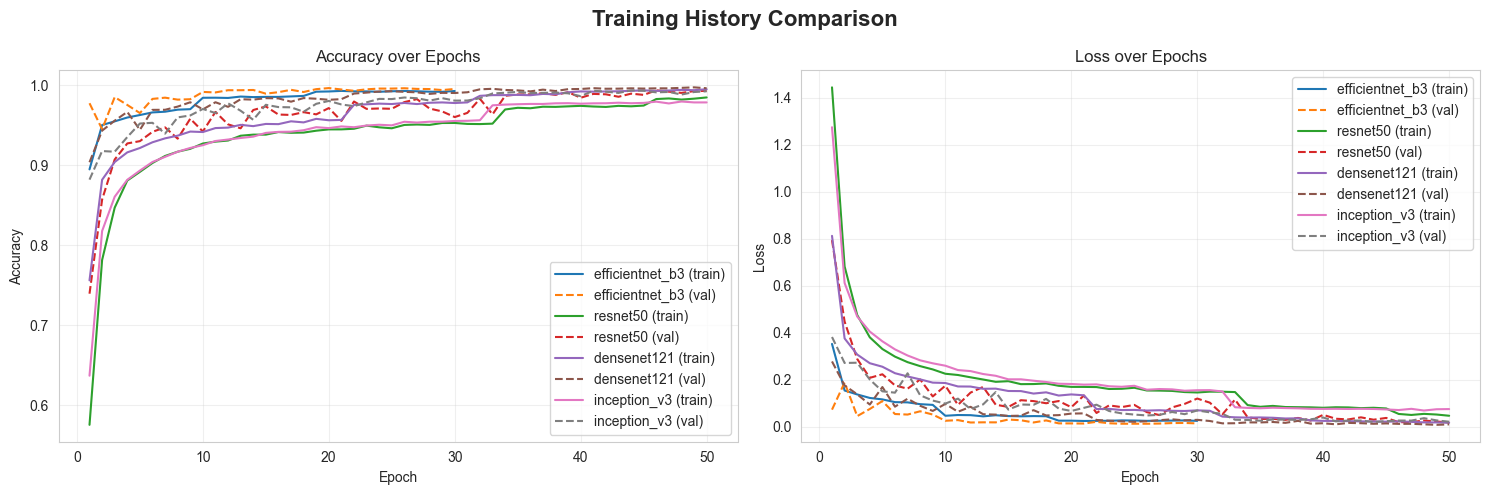

In [14]:
def plot_training_history(histories):
    """
    Plot training history for all models
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('Training History Comparison', fontsize=16, fontweight='bold')
    
    # Plot accuracy
    ax = axes[0]
    for model_name, history in histories.items():
        epochs_range = range(1, len(history['train_acc']) + 1)
        ax.plot(epochs_range, history['train_acc'], label=f'{model_name} (train)', linestyle='-')
        ax.plot(epochs_range, history['val_acc'], label=f'{model_name} (val)', linestyle='--')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy over Epochs')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot loss
    ax = axes[1]
    for model_name, history in histories.items():
        epochs_range = range(1, len(history['train_loss']) + 1)
        ax.plot(epochs_range, history['train_loss'], label=f'{model_name} (train)', linestyle='-')
        ax.plot(epochs_range, history['val_loss'], label=f'{model_name} (val)', linestyle='--')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Loss over Epochs')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(MODEL_SAVE_PATH / 'training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot training history
plot_training_history(training_histories)

## 10. Evaluate Individual Models on Test Set

In [15]:
# Evaluate each model
individual_results = {}

for model_name, model in trained_models.items():
    print(f"\nEvaluating {model_name}...")
    
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f'Testing {model_name}'):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            
            test_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = test_loss / total
    test_acc = correct / total
    test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    test_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    # Store results
    individual_results[model_name] = {
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1
    }
    
    print(f"{model_name} Results:")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Test Precision: {test_precision:.4f}")
    print(f"  Test Recall: {test_recall:.4f}")
    print(f"  Test F1-Score: {test_f1:.4f}")

# Create results DataFrame
results_df = pd.DataFrame(individual_results).T
print("\n" + "="*70)
print("Individual Model Results:")
print("="*70)
print(results_df)


Evaluating efficientnet_b3...


Testing efficientnet_b3: 100%|██████████| 170/170 [00:35<00:00,  4.74it/s]


efficientnet_b3 Results:
  Test Loss: 0.0140
  Test Accuracy: 0.9963
  Test Precision: 0.9964
  Test Recall: 0.9963
  Test F1-Score: 0.9963

Evaluating resnet50...


Testing resnet50: 100%|██████████| 170/170 [00:13<00:00, 12.92it/s]



resnet50 Results:
  Test Loss: 0.0190
  Test Accuracy: 0.9945
  Test Precision: 0.9946
  Test Recall: 0.9945
  Test F1-Score: 0.9944

Evaluating densenet121...


Testing densenet121: 100%|██████████| 170/170 [00:13<00:00, 12.34it/s]


densenet121 Results:
  Test Loss: 0.0138
  Test Accuracy: 0.9965
  Test Precision: 0.9965
  Test Recall: 0.9965
  Test F1-Score: 0.9965

Evaluating inception_v3...


Testing inception_v3: 100%|██████████| 170/170 [00:10<00:00, 15.51it/s]

inception_v3 Results:
  Test Loss: 0.0276
  Test Accuracy: 0.9921
  Test Precision: 0.9922
  Test Recall: 0.9921
  Test F1-Score: 0.9920

Individual Model Results:
                 test_loss  test_accuracy  test_precision  test_recall  \
efficientnet_b3   0.013953       0.996317        0.996397     0.996317   
resnet50          0.018973       0.994476        0.994608     0.994476   
densenet121       0.013817       0.996502        0.996524     0.996502   
inception_v3      0.027579       0.992082        0.992240     0.992082   

                  test_f1  
efficientnet_b3  0.996292  
resnet50         0.994439  
densenet121      0.996506  
inception_v3     0.992041  


## 11. Build Ensemble Model

In [16]:
class EnsembleModel(nn.Module):
    """
    Ensemble model that averages predictions from multiple models
    """
    def __init__(self, models_dict):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(list(models_dict.values()))
        self.num_models = len(self.models)
    
    def forward(self, x):
        # Get predictions from all models
        outputs = []
        for model in self.models:
            model.eval()
            with torch.no_grad():
                output = model(x)
            outputs.append(output)
        
        # Average predictions
        ensemble_output = torch.stack(outputs).mean(dim=0)
        return ensemble_output

# Create ensemble
ensemble_model = EnsembleModel(trained_models)
ensemble_model = ensemble_model.to(device)
ensemble_model.eval()

print("Ensemble model created!")
print(f"Number of models in ensemble: {len(trained_models)}")
print(f"Models: {list(trained_models.keys())}")

Ensemble model created!
Number of models in ensemble: 4
Models: ['efficientnet_b3', 'resnet50', 'densenet121', 'inception_v3']


## 12. Evaluate Ensemble Model

In [17]:
# Evaluate ensemble model
print("Evaluating Ensemble Model...")

ensemble_model.eval()
test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing Ensemble'):
        images, labels = images.to(device), labels.to(device)
        
        outputs = ensemble_model(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        
        test_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / total
test_acc = correct / total
test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
test_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print("\n" + "="*70)
print("ENSEMBLE MODEL RESULTS:")
print("="*70)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

# Add ensemble results to comparison
individual_results['Ensemble'] = {
    'test_loss': test_loss,
    'test_accuracy': test_acc,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_f1': test_f1
}

# Final comparison
final_results_df = pd.DataFrame(individual_results).T
print("\n" + "="*70)
print("FINAL COMPARISON (All Models + Ensemble):")
print("="*70)
print(final_results_df.sort_values('test_accuracy', ascending=False))

Evaluating Ensemble Model...


Testing Ensemble: 100%|██████████| 170/170 [00:30<00:00,  5.62it/s]


ENSEMBLE MODEL RESULTS:
Test Loss: 0.0099
Test Accuracy: 0.9974
Test Precision: 0.9975
Test Recall: 0.9974
Test F1-Score: 0.9974

FINAL COMPARISON (All Models + Ensemble):
                 test_loss  test_accuracy  test_precision  test_recall  \
Ensemble          0.009874       0.997422        0.997456     0.997422   
densenet121       0.013817       0.996502        0.996524     0.996502   
efficientnet_b3   0.013953       0.996317        0.996397     0.996317   
resnet50          0.018973       0.994476        0.994608     0.994476   
inception_v3      0.027579       0.992082        0.992240     0.992082   

                  test_f1  
Ensemble         0.997408  
densenet121      0.996506  
efficientnet_b3  0.996292  
resnet50         0.994439  
inception_v3     0.992041  


## 13. Visualize Final Results

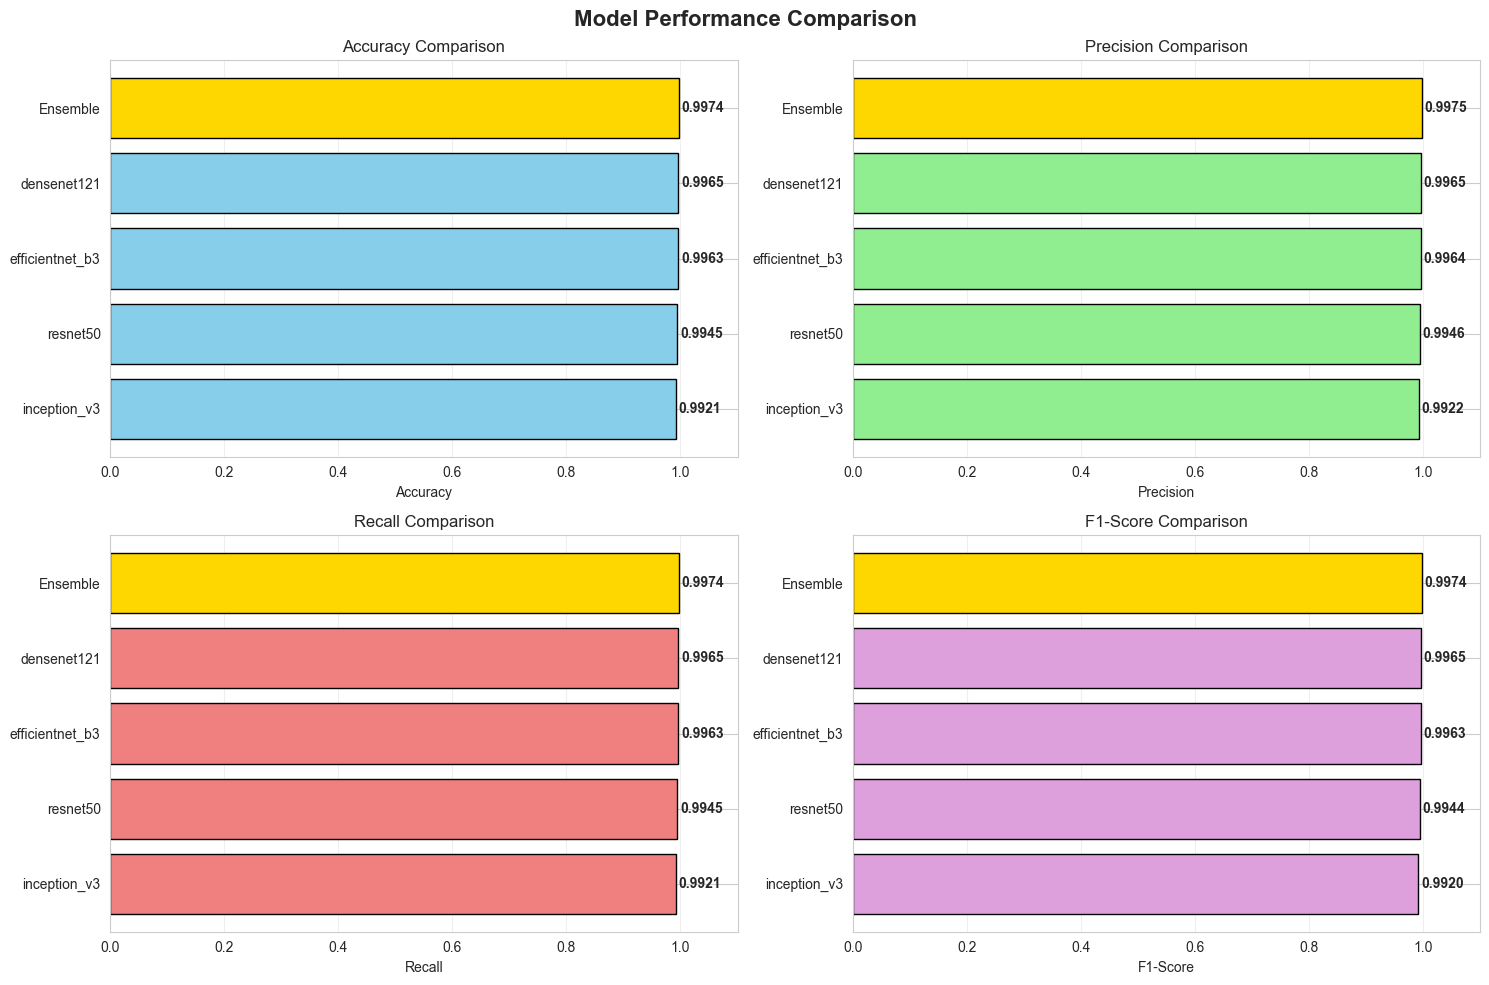

In [18]:
# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']
titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['skyblue', 'lightgreen', 'lightcoral', 'plum']

for idx, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Sort by metric
    sorted_df = final_results_df.sort_values(metric, ascending=True)
    
    # Highlight ensemble
    colors_list = [color if name != 'Ensemble' else 'gold' for name in sorted_df.index]
    
    # Plot
    bars = ax.barh(sorted_df.index, sorted_df[metric], color=colors_list, edgecolor='black')
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.005, bar.get_y() + bar.get_height()/2, 
                f'{width:.4f}', ha='left', va='center', fontweight='bold')
    
    ax.set_xlabel(title)
    ax.set_title(f'{title} Comparison')
    ax.grid(axis='x', alpha=0.3)
    ax.set_xlim(0, 1.1)

plt.tight_layout()
plt.savefig(MODEL_SAVE_PATH / 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 14. Save Models and Results

In [19]:
# Save ensemble model
torch.save(ensemble_model.state_dict(), MODEL_SAVE_PATH / 'ensemble_model.pth')
print(f"Ensemble model saved to: {MODEL_SAVE_PATH / 'ensemble_model.pth'}")

# Save individual models
for model_name, model in trained_models.items():
    torch.save(model.state_dict(), MODEL_SAVE_PATH / f'{model_name}_final.pth')
print(f"Individual models saved")

# Save results to CSV
final_results_df.to_csv(MODEL_SAVE_PATH / 'model_results.csv')
print(f"Results saved to: {MODEL_SAVE_PATH / 'model_results.csv'}")

# Save class mappings
with open(MODEL_SAVE_PATH / 'class_mappings.json', 'w') as f:
    json.dump({
        'class_to_idx': class_to_idx,
        'idx_to_class': idx_to_class,
        'num_classes': num_classes
    }, f, indent=2)
print(f"Class mappings saved to: {MODEL_SAVE_PATH / 'class_mappings.json'}")

# Save training histories
with open(MODEL_SAVE_PATH / 'training_histories.json', 'w') as f:
    # Convert numpy arrays to lists for JSON serialization
    histories_json = {}
    for model_name, history in training_histories.items():
        histories_json[model_name] = {
            key: [float(v) for v in values] 
            for key, values in history.items()
        }
    json.dump(histories_json, f, indent=2)
print(f"Training histories saved to: {MODEL_SAVE_PATH / 'training_histories.json'}")

print("\nAll models and results saved successfully!")

Ensemble model saved to: g:\Dataset\models\ensemble_model.pth
Individual models saved
Results saved to: g:\Dataset\models\model_results.csv
Class mappings saved to: g:\Dataset\models\class_mappings.json
Training histories saved to: g:\Dataset\models\training_histories.json

All models and results saved successfully!
Individual models saved
Results saved to: g:\Dataset\models\model_results.csv
Class mappings saved to: g:\Dataset\models\class_mappings.json
Training histories saved to: g:\Dataset\models\training_histories.json

All models and results saved successfully!


## 15. Summary và Kết luận

In [20]:
print("\n" + "="*70)
print(" "*20 + "FINAL SUMMARY")
print("="*70)

print(f"\nDataset: PlantVillage")
print(f"Total Classes: {num_classes}")
print(f"Total Images: {len(X_paths)}")
print(f"  - Train: {len(X_train)}")
print(f"  - Validation: {len(X_val)}")
print(f"  - Test: {len(X_test)}")

print(f"\nModels Trained:")
for model_name in ENSEMBLE_MODELS:
    print(f"  - {model_name}")

print(f"\nBest Individual Model:")
best_individual = final_results_df[final_results_df.index != 'Ensemble'].sort_values(
    'test_accuracy', ascending=False
).iloc[0]
best_model_name = final_results_df[final_results_df.index != 'Ensemble'].sort_values(
    'test_accuracy', ascending=False
).index[0]
print(f"  Model: {best_model_name}")
print(f"  Accuracy: {best_individual['test_accuracy']:.4f}")

print(f"\nEnsemble Model:")
ensemble_acc = final_results_df.loc['Ensemble', 'test_accuracy']
print(f"  Accuracy: {ensemble_acc:.4f}")

improvement = (ensemble_acc - best_individual['test_accuracy']) * 100
if improvement > 0:
    print(f"  Improvement over best individual: +{improvement:.2f}%")
else:
    print(f"  Difference from best individual: {improvement:.2f}%")

print("\n" + "="*70)
print("Training and Evaluation Complete!")
print("="*70)


                    FINAL SUMMARY

Dataset: PlantVillage
Total Classes: 39
Total Images: 54305
  - Train: 39099
  - Validation: 9775
  - Test: 5431

Models Trained:
  - efficientnet_b3
  - resnet50
  - densenet121
  - inception_v3

Best Individual Model:
  Model: densenet121
  Accuracy: 0.9965

Ensemble Model:
  Accuracy: 0.9974
  Improvement over best individual: +0.09%

Training and Evaluation Complete!
